#### Flower classification by using VisionTransformer (encoder)

In [1]:
import os
import math
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision.ops import MLP
%matplotlib inline

from einops import einops, rearrange
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import torch.utils.data
import torch.optim as optim

import warnings
warnings.filterwarnings("ignore")

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('my device :', device)

my device : cpu


In [3]:
train_dir = "D:\\data\\archive\\train"
test_dir = "D:\\data\\archive\\val"

In [4]:
workers = os.cpu_count()

def create_dataloader(train_dir : str, 
                      test_dir : str,
                      transform: transforms.Compose,
                      batch_size: int,
                      num_workers: workers):
    train_data = datasets.ImageFolder(train_dir,transform=transform)
    test_data = datasets.ImageFolder(test_dir,transform=transform)
    class_name = train_data.classes
    
    train_loader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )
    test_loader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    return train_loader, test_loader, class_name

In [5]:
img_size = 224
manual_transform = transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor(),
])
print(f"Manually transforming: {manual_transform}")

Manually transforming: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [6]:
BATCH_SIZE =1

train_loader, test_loader, class_name = create_dataloader(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transform,
    batch_size=BATCH_SIZE,
    num_workers=workers
)
print(f"Train: {len(train_loader)} Test: {len(test_loader)}")
print(f"Classes: {class_name}")

Train: 1741 Test: 42
Classes: ['common_daisy', 'dandelion', 'iris', 'rose', 'sunflower', 'tulip']


torch.Size([3, 224, 224]) tensor(1)


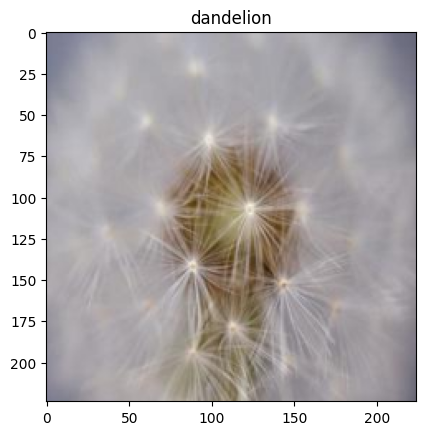

In [7]:
image_batch, label_batch = next(iter(train_loader))
#taking single image from the batch
image, label = image_batch[0], label_batch[0]
#view the batch shapes
print(image.shape, label)

plt.imshow(image.permute(1,2,0)) #rearrange image dims foe matplotlib[channels, height, width]
plt.title(class_name[label])
plt.show()

![title](ViT_structure.png)

In [8]:
patch_size = 16
latent_size = 768
n_channels = 3
num_heads =3
num_encoders = 4
dropout = 0.2
num_classes = 6

epochs = 5
lr = 10e-3
batch_size = BATCH_SIZE
weight_decay = 0.03

In [9]:
image_batch.shape

torch.Size([1, 3, 224, 224])

In [10]:
class InputEmbedding(nn.Module):
    def __init__(self, patch_size=patch_size, n_channels=n_channels, latent_size=latent_size,batch_size=BATCH_SIZE):
        super(InputEmbedding, self).__init__()
        self.patch_size = patch_size
        self.n_channels = n_channels
        self.latent_size = latent_size
        self.batch_size = batch_size
        self.input_size = self.patch_size * self.patch_size * self.n_channels
        
        #linear projection
        self.linearProjection = nn.Linear(self.input_size, self.latent_size)
        
        self.class_token = nn.Parameter(torch.randn(self.batch_size, 1, self.latent_size))
        
        self.pos_embed = nn.Parameter(torch.randn(self.batch_size, 1, self.latent_size))
        
    def forward(self, input_data):
        input_data = input_data
        #patching input images
        patches = einops.rearrange(input_data,
                                   'b c (h h1) (w w1) -> b (h w) (h1 w1 c)',
                                   h1=self.patch_size,
                                   w1=self.patch_size)
        #print(input_data.size())
        #print(patches.size())
        
        linear_projection = self.linearProjection(patches)
        b,n, _ = linear_projection.shape #batch, num_patches, p*p*c
        
        linear_projection = torch.cat((self.class_token, linear_projection), dim=1) #concate in dim 1 wise [batch, num_patch+1, latent_size]
        pos_embed = einops.repeat(self.pos_embed,'b 1 d -> b m d',m=n+1)  # here n is the number of pacthes
        #print(linear_projection.size())
        #print(pos_embed.size())
        linear_projection += pos_embed
        return linear_projection

In [11]:
test_class = InputEmbedding()
embed_test=test_class(image_batch)

### Initialize Encoder part

In [12]:
class EncoderBlock(nn.Module):
    def __init__(self, latent_size=latent_size, num_heads=num_heads, dropout=dropout):
        super(EncoderBlock, self).__init__()
        
        self.latent_size = latent_size
        self.num_heads = num_heads
        self.dropout = dropout
        
        self.norm = nn.LayerNorm(self.latent_size)
        self.multihead = nn.MultiheadAttention(
            self.latent_size, self.num_heads, dropout=self.dropout)
        self.enc_mlp = nn.Sequential(
            nn.Linear(self.latent_size, self.latent_size*4),
            nn.GELU(),
            nn.Dropout(self.dropout),
            nn.Linear(self.latent_size*4, self.latent_size),
            nn.Dropout(self.dropout),
        )
        
    def forward(self, embedded_patches):
        firestorm_output = self.norm(embedded_patches)
        attention_out = self.multihead(firestorm_output,
                                       firestorm_output,firestorm_output)[0] #Q, K, V
        #residual
        first_added = attention_out + embedded_patches
        secondnorm_output = self.norm(first_added)
        mlp_output = self.enc_mlp(secondnorm_output)
        out = mlp_output+first_added
        
        #print(embedded_patches.size())
        #print(out.size())
        
        return out
        

In [13]:
test_encoder = EncoderBlock()
test_encoder(embed_test)

tensor([[[ 0.9424,  1.1492,  0.3973,  ...,  0.5872, -1.9791,  1.8784],
         [ 0.4761, -0.4666, -0.2531,  ...,  0.6295, -1.0504,  1.9791],
         [-0.5056, -0.4471, -0.1747,  ...,  0.0366, -0.7757,  1.4868],
         ...,
         [-0.1438, -0.3176,  0.2115,  ...,  0.3404, -0.0748,  1.6634],
         [ 0.9778,  0.1377, -0.2431,  ...,  1.3752,  0.0572,  1.5068],
         [-0.1148, -0.0559, -0.1269,  ...,  0.2758, -0.8172,  1.1970]]],
       grad_fn=<AddBackward0>)

In [14]:
class ViT(nn.Module):
    def __init__(self, num_encoders=num_encoders, num_classes=num_classes, latent_size=latent_size, dropout=dropout):
        super(ViT, self).__init__()
        self.num_encoders = num_encoders
        self.num_classes = num_classes
        self.latent_size = latent_size
        self.dropout = dropout
        
        self.embedding = InputEmbedding()
        #stacking encoders
        self.enc_stack= nn.ModuleList([
            EncoderBlock() for i in range(self.num_encoders)
        ])
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(self.latent_size),
            nn.Linear(self.latent_size, self.latent_size//2),
            nn.ReLU(),
            nn.Linear(self.latent_size//2, self.num_classes),
        )
        
    def forward(self, x):
        enc_output = self.embedding(x)
        
        for enc_layer in self.enc_stack:
            enc_output = enc_layer(enc_output)
        cls_token_embed = enc_output[:, 0]
        
        return self.mlp_head(cls_token_embed)

In [15]:
model = ViT(num_encoders=num_encoders, num_classes=num_classes, latent_size=latent_size, dropout=dropout)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

In [16]:
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):

        optimizer.zero_grad()  # Clear previous gradients
        
        # Forward pass
        output = model(inputs)
        # Calculate loss
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if batch_idx % 100 == 0:
            print('Batch :{} epoch: {} has Loss {:.4f}'.format(batch_idx, epoch, total_loss/100))
            total_loss = 0

Batch :0 epoch: 0 has Loss 0.0199
Batch :100 epoch: 0 has Loss 7.0886
Batch :200 epoch: 0 has Loss 2.3058
Batch :300 epoch: 0 has Loss 1.9754
Batch :400 epoch: 0 has Loss 1.8613
Batch :500 epoch: 0 has Loss 1.8452
Batch :600 epoch: 0 has Loss 1.8041
Batch :700 epoch: 0 has Loss 1.7851
Batch :800 epoch: 0 has Loss 1.8090
Batch :900 epoch: 0 has Loss 1.8022
Batch :1000 epoch: 0 has Loss 1.7912
Batch :1100 epoch: 0 has Loss 1.7857
Batch :1200 epoch: 0 has Loss 1.7865
Batch :1300 epoch: 0 has Loss 1.7656
Batch :1400 epoch: 0 has Loss 1.8012
Batch :1500 epoch: 0 has Loss 1.7673
Batch :1600 epoch: 0 has Loss 1.7838
Batch :1700 epoch: 0 has Loss 1.7955
Batch :0 epoch: 1 has Loss 0.0186
Batch :100 epoch: 1 has Loss 1.8000
Batch :200 epoch: 1 has Loss 1.7977
Batch :300 epoch: 1 has Loss 1.7838
Batch :400 epoch: 1 has Loss 1.7955
Batch :500 epoch: 1 has Loss 1.7696
Batch :600 epoch: 1 has Loss 1.7895
Batch :700 epoch: 1 has Loss 1.8033
Batch :800 epoch: 1 has Loss 1.7887
Batch :900 epoch: 1 has 

KeyboardInterrupt: 

For the sake of time I have cancelled the training process.
### Thanks